In [1]:
"""
This code implement the Actor Critic Alogrithms
"""
import numpy as np
import pandas as pd
import gym
from collections import namedtuple
import matplotlib
from matplotlib import pyplot as plt

from keras.layers.core import Dense, Dropout, Activation
import keras.backend as K
from keras import models,layers,optimizers
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
RENDER_ENV = False
LEARNING_RATE_ACTOR = 0.001
LEARNING_RATE_CRITIC = 0.01
GAMMA = 0.9
OUTPUT_GRAPH = False
ENVNAME = "CartPole-v0"
NUM_EPISODES = 500

In [3]:
class Actor(object):
    def __init__(self, n_features, n_actions, lr=0.001):
        self.n_features = n_features
        self.n_actions = n_actions
        self.lr = lr
        self.__build_network()
        self.__train_network()
        
    def __build_network(self):        
        self.input_s = layers.Input(shape=(self.n_features,))
        net = self.input_s
        net = layers.Dense(20)(net)
        net = layers.Activation("relu")(net)
        net = layers.Dense(self.n_actions)(net)
        net = layers.Activation("softmax")(net)
        self.model = models.Model(inputs=self.input_s, outputs=net)
        self.model.summary()
    
    def __train_network(self):
        self.action_prob_placeholder = self.model.output
        self.action_placeholder = K.placeholder(shape=(),dtype=np.int32,name= "action")
        self.td_error_placeholder = K.placeholder(shape=[1,1],dtype=np.float32,name="td_error")
        
        self.log_prob = K.log(self.action_prob_placeholder[0, self.action_placeholder])
        self.exp_v = K.mean(self.log_prob * self.td_error_placeholder)
        
        adam = optimizers.Adam(lr=self.lr)
        updates = adam.get_updates(params=self.model.trainable_weights,loss= -self.exp_v)
        self.train_fn = K.function(inputs=[self.model.input,
                                          self.action_placeholder,
                                          self.td_error_placeholder],
                                   outputs=[self.model.output, self.exp_v],
                                   updates=updates)        

    def learn(self, s, a, td):
        s = s[np.newaxis, :]
        _, exp_v = self.train_fn([s, a, td])
        return exp_v

    def choose_action(self, s):
        s = s[np.newaxis, :]
        probs = self.model.predict(s)
        return np.random.choice(np.arange(probs.shape[1]), p=probs.ravel())   # return a int


class Critic(object):
    def __init__(self, n_features, lr=0.01):
        self.n_features = n_features
        self.lr = lr
        self.__build_network()
        self.__train_network()
        
    def __build_network(self):        
        self.input_s = layers.Input(shape=(self.n_features,))
        net = self.input_s
        net = layers.Dense(20)(net)
        net = layers.Activation("relu")(net)
        net = layers.Dense(1)(net)
        self.model = models.Model(inputs=self.input_s, outputs=net)
        self.model.summary()
    
    def __train_network(self):
        self.v = self.model.output
        self.v_ = K.placeholder(shape=(1, 1), name= "v_next")
        self.r = K.placeholder(shape=(1,1), name="reward")
        self.td_error = self.r + GAMMA * self.v_ - self.v
        self.loss = K.square(self.td_error)
        
        adam = optimizers.Adam(lr=self.lr)
        updates = adam.get_updates(params=self.model.trainable_weights,loss=self.loss)
        self.train_fn = K.function(inputs=[self.model.input,
                                          self.v_,
                                          self.r],
                                   outputs=[self.td_error, self.model.output],
                                   updates=updates)
        
    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]
        v_ = self.model.predict(s_)
        td_error, _ = self.train_fn([s, v_, r])
        return td_error

In [4]:
def plot_episode_stats1(rec, xlabel, ylabel,title):
    fig = plt.figure(figsize=(20, 10), facecolor = "white")
    ax = fig.add_subplot(111)
    ax.plot(rec) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig

def plot_episode_stats2(stats):
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(20, 10))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    return fig3

def Plot_the_result(rec):
    # Plot episode length over time
    episode_lengths = rec.episode_lengths
    fig = plot_episode_stats1(episode_lengths, 
                       xlabel = "Episode",
                       ylabel = "Episode Length",
                       title = "Episode length over Time"
            )
    fig.show()
    fig.savefig("./log/AC_keras_CartPole_EpisodeLength.jpg")

    # Plot Episode reward over time
    smoohing_window = 10
    reward_smooths = pd.Series(rec.episode_rewards).rolling(smoohing_window,\
                    min_periods = smoohing_window).mean()
    fig = plot_episode_stats1(reward_smooths, 
                       xlabel = "Episode",
                       ylabel = "Episode Reward",
                       title = "Episode reward over time"
            )
    fig.show()
    fig.savefig("./log/AC_keras_CartPole_EpisodeReward.jpg")
    
    # Plot Episode per time step
    fig = plot_episode_stats2(rec)
    fig.show()
    fig.savefig("./log/AC_keras_CartPole_EpisodePerTimeStep.jpg")

In [5]:
def update(actor, critic, env, num_episodes):
    # Track the statistics of the result
    record = namedtuple("Record", ["episode_lengths","episode_rewards"])
    
    rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        if 0 == (i_episode +1) % 1:
            print("This the episode {}/{}".format(i_episode, num_episodes), end = "\r")
        observation = env.reset()
        step =0
        reward_cum = 0
        done = False
        while True:
            #env.render()
            if RENDER_ENV:
                env.render()
            action = actor.choose_action(observation)
            observation_next, reward, done, info = env.step(action)
            if done:
                reward = -20
            # update the record
            step += 1
            rec.episode_lengths[i_episode] = step 
            rec.episode_rewards[i_episode] += reward
            td_error = critic.learn(observation, reward, observation_next)
            actor.learn(observation, action, td_error)
            if done:
                if 0 == (i_episode +1) % 5:
                    print("The reward at episode {} is {}.".format(i_episode, 
                                            rec.episode_rewards[i_episode]))
                break
            observation = observation_next
    print("Finished")
    env.close()
    return rec

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape  

/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


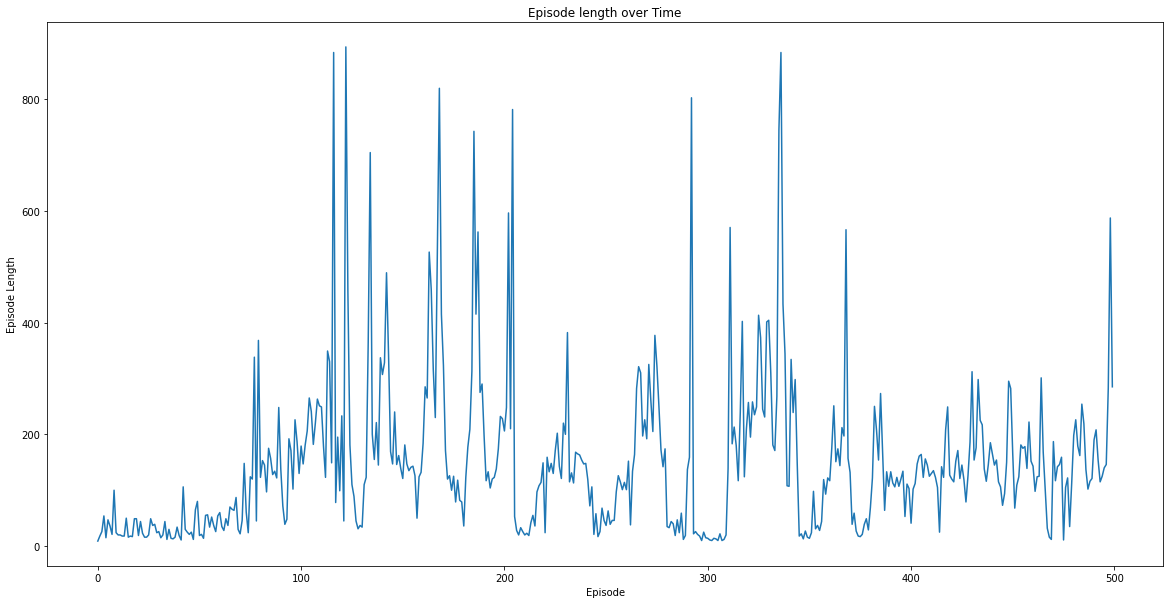

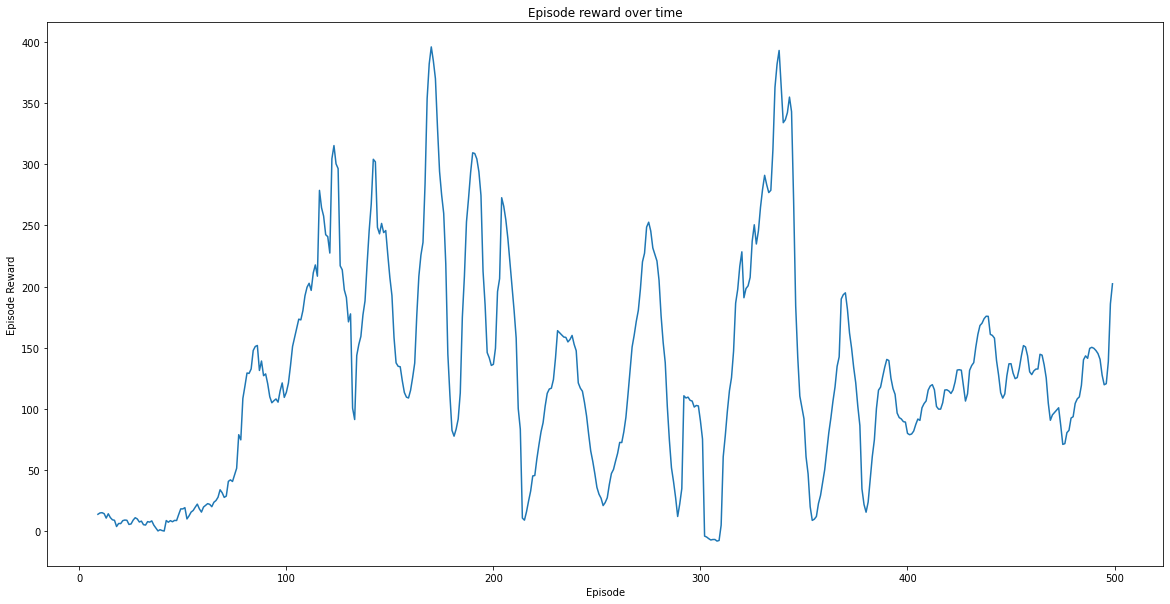

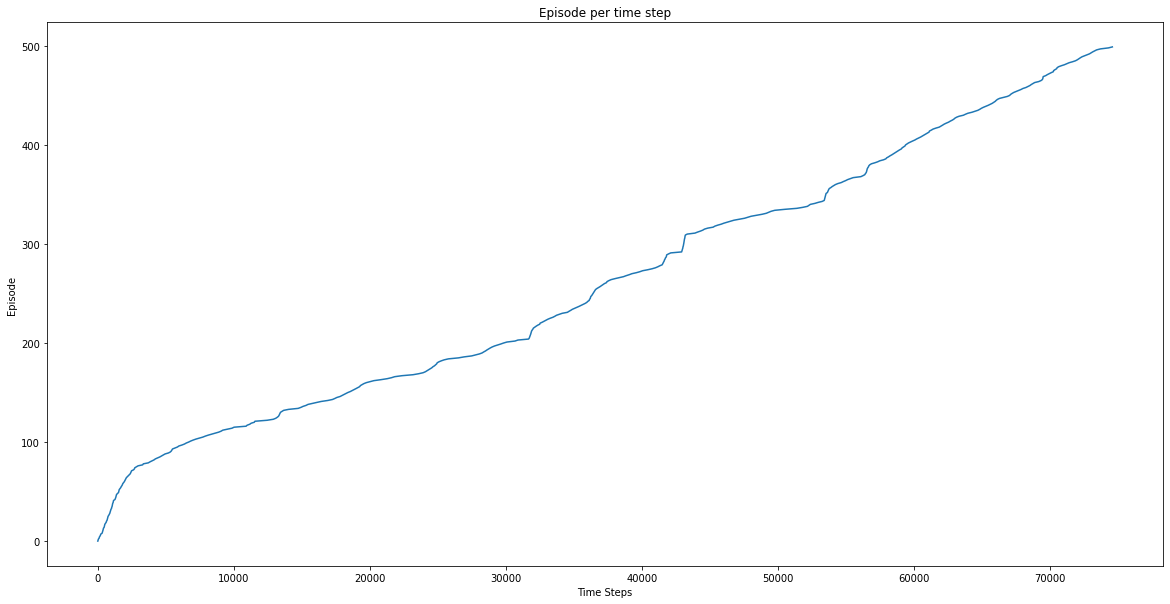

In [6]:
if __name__ == "__main__":
    env = gym.envs.make(ENVNAME)
    env = env.unwrapped
    env.seed(1)
    n_action = env.action_space.n
    n_feature = env.observation_space.shape[0]
    
    actor = Actor(n_features=n_feature, n_actions=n_action, lr=LEARNING_RATE_ACTOR)
    critic = Critic(n_features=n_feature, lr=LEARNING_RATE_CRITIC) 

    rec = update(actor, critic, env, num_episodes=NUM_EPISODES)
    #Plot the result
    Plot_the_result(rec)